# Cirrus Price Analysis

This notebook is an extension of the excellent analysis at https://rstudio-pubs-static.s3.amazonaws.com/222505_5cc603652e6344879dc5028ddf660688.html. This reimplements the original R code into Python. It also extends the data from the original 2016 set to the latest available in 2019. It also adds the SR22 G6, and the SR20 (G3 and G6).

A few notes:
  - This update only really looks at aircraft age, model, TTSN. and Turbo, which seem to be the most significant factors.
  - This includes the original data, combined with a recent snapshot around 4/16/2019.

In [16]:
# Import all the modules we'll need later
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sbn

sbn.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 100

# Load the data
datafile = 'updated_cirrus.csv'
data = pd.read_csv(datafile)

# Derive/convert some of the columns to more directly useful
data = data.assign(last_update=pd.to_datetime(data['Last update']))
data = data.assign(age=(data.last_update.dt.year - data.Year))
data.Price = data.Price / 1000


Populating the interactive namespace from numpy and matplotlib


# Data

Let’s start by looking at the data collection, copied primarily from controller.com listings. We have a total of 177 airplanes from 2008 to 2018. All of them use Garmin Perspective avionics so are either G3 (87 airplanes) or G5 (75 airplanes), or G6 (15 airplanes). The engine is either Turbo (105 airplanes), Turbo Normalized (17 airplanes) or normally aspirated (55 airplanes). 

To simplify, let’s start by looking at airplane cost simply as a function of total flight time, ignoring top overhauls and airplane features. We’ll combine the effect of multiple variables later:

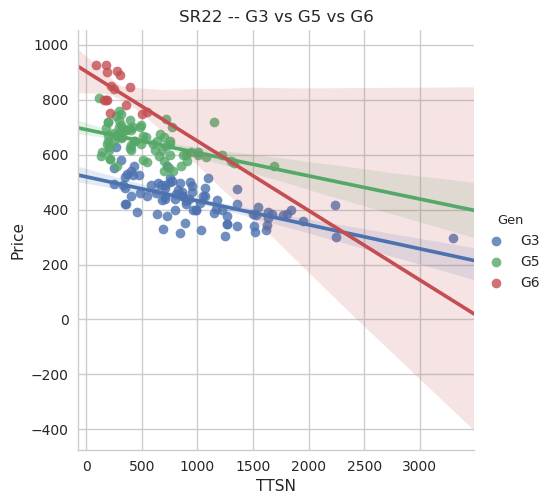

In [17]:
#ggplot(data = data, aes(x=TTSN, y=Price, color=Gen)) + geom_point() + geom_smooth(method=glm)

fig = sbn.lmplot('TTSN', 'Price', data, hue='Gen')
_ = title('SR22 -- G3 vs G5 vs G6')

Note: Prices are in aviation units ($1K) and are asking prices. This is important because not all airplanes are realistically priced, and some prices go down significantly at sale.

The plotted lines are just smoothing using linear regression. They don’t represent real planes (which are in the points), but rather a statistical attempt to capture the trend, with 95% confidence interval (in gray bands).

Clearly, G5s command a significantly higher asking price premium ($100K+) over G3s for equivalent hours.

G6's command an even higher premium (another $120k), but are depreciating quicker, likely because they are a relatively new model as of the observations in 2019.

# Effect of the engine type

We can look at the G5s and G6s separately for an evluation of the ‘Turbo’ premium:

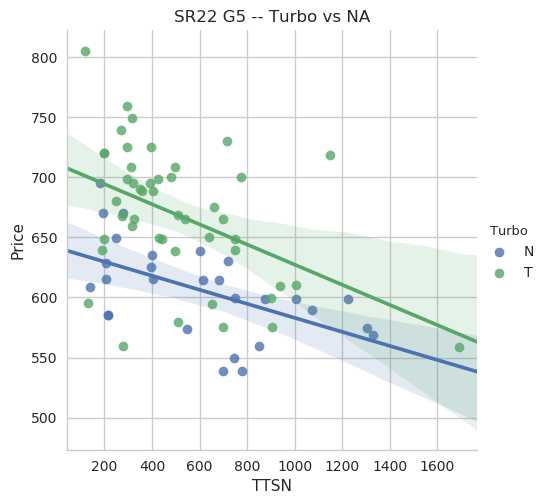

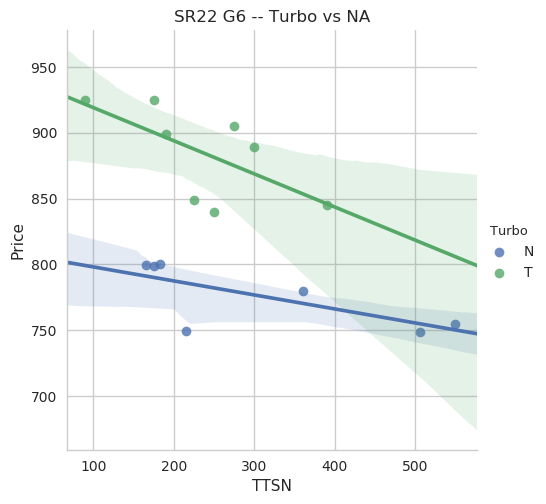

In [57]:
# ggplot(data = subset(data, Gen=='G5'), aes(x=TTSN, y=Price, color=Turbo)) + geom_point() + geom_smooth(method=glm)
g5_data = data[data.Gen == 'G5']
g6_data = data[data.Gen == 'G6']

sbn.lmplot('TTSN', 'Price', g5_data, hue='Turbo')
_ = title('SR22 G5 -- Turbo vs NA')

sbn.lmplot('TTSN', 'Price', g6_data, hue='Turbo')
_ = title('SR22 G6 -- Turbo vs NA')

It appears that Turbo engines do deppreciate faster than NAs, likely because of the increased overhhaul cost.

The Turbo option on the G6 commands a much higher premium than on the G5, although it also depreciates quicker. This may also be explained by other variables (for example, Turbo G6's always have other additional options), but nevertheless the price premium can be associated with the Turbo option. Still, there aren't may G6 airplanes for sale yet, so it's hard to make strong conclusions.

# Aircraft Age
Next, let's look at how price depreciates as a function of age.

Unfortunately, the G6's haven't been around long enough, so we'll skip those.

/usr/lib/python3/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


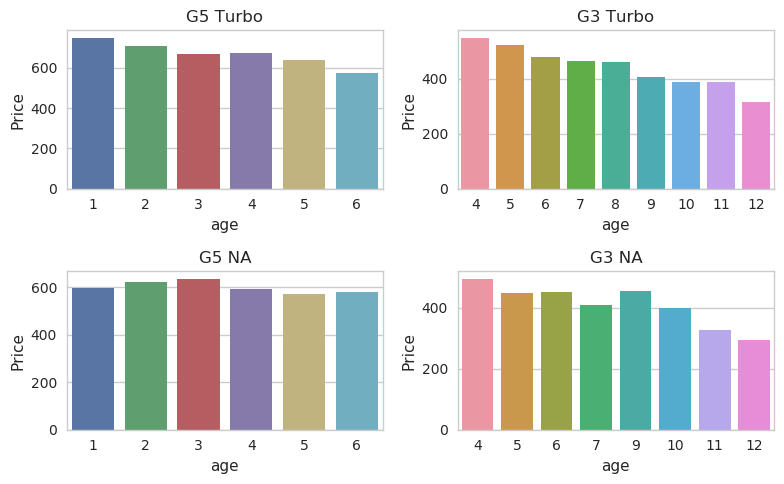

In [59]:
fig = figure(figsize=(8, 5))


subplot(2, 2, 1)
grouped_data = data[(data.Gen == 'G5') & (data.Turbo == 'T')].groupby('age')
sbn.barplot(grouped_data.age.median(), grouped_data.Price.median())
_ = title('G5 Turbo')

subplot(2, 2, 3)
grouped_data = data[(data.Gen == 'G5') & (data.Turbo == 'N')].groupby('age')
sbn.barplot(grouped_data.age.median(), grouped_data.Price.median())
_ = title('G5 NA')

subplot(2, 2, 2)
grouped_data = data[(data.Gen == 'G3') & (data.Turbo == 'T')].groupby('age')
sbn.barplot(grouped_data.age.median(), grouped_data.Price.median())
_ = title('G3 Turbo')

subplot(2, 2, 4)
grouped_data = data[(data.Gen == 'G3') & (data.Turbo == 'N')].groupby('age')
sbn.barplot(grouped_data.age.median(), grouped_data.Price.median())
_ = title('G3 NA')

fig.tight_layout()


Non-turbo G5s show very little depreciation with age so far, while Turbo's depreciate much quicker. This is probably a combination of more expensive engine overhauls, and that the buyers of Turbos are more in the premium market and upgrade to a G6.

The G3's on the other hand depreciate much faster than the G5for both Turbo and NA models. This is likely because Cirrus is iterating on the SR22 so quickly, older models are quickly less desirable than newer ones.

# Linear regression
Finally, let’s try to combine all the factors into a single predictive cost model (looking separately at G3 and G5):

In [63]:
gen = data.Gen == 'G6'
gen_data = data[gen][ ['age', 'TTSN', 'Turbo'] ]
gen_data.Turbo = (gen_data.Turbo == 'T').astype(float)

target = data[gen].Price.values

X = sm.add_constant(gen_data)
est = sm.OLS(target, X)
est6 = est.fit_regularized('elastic_net', refit=True)
print(est6.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     36.05
Date:                Sun, 21 Apr 2019   Prob (F-statistic):           5.52e-06
Time:                        14:40:45   Log-Likelihood:                -65.131
No. Observations:                  15   AIC:                             138.3
Df Residuals:                      11   BIC:                             141.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        878.6987     36.569     24.029      0.0

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


In [64]:
gen = data.Gen == 'G5'
gen_data = data[gen][ ['age', 'TTSN', 'Turbo'] ]
gen_data.Turbo = (gen_data.Turbo == 'T').astype(float)

target = data[gen].Price.values

X = sm.add_constant(gen_data)
est = sm.OLS(target, X)
est5 = est.fit_regularized('elastic_net', refit=True)
print(est5.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     36.87
Date:                Sun, 21 Apr 2019   Prob (F-statistic):           1.77e-14
Time:                        14:40:46   Log-Likelihood:                -375.64
No. Observations:                  75   AIC:                             759.3
Df Residuals:                      71   BIC:                             768.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        680.0648     11.956     56.881      0.0

In [66]:
gen = data.Gen == 'G3'
gen_data = data[gen][ ['age', 'TTSN', 'Turbo'] ]
gen_data.Turbo = (gen_data.Turbo == 'T').astype(float)

target = data[gen].Price.values

X = sm.add_constant(gen_data)
est = sm.OLS(target, X)
est3 = est.fit_regularized('elastic_net', refit=True)
print(est3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     108.2
Date:                Sun, 21 Apr 2019   Prob (F-statistic):           1.37e-28
Time:                        14:40:49   Log-Likelihood:                -423.93
No. Observations:                  87   AIC:                             855.9
Df Residuals:                      83   BIC:                             865.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        593.8031     11.688     50.803      0.0

It's difficult to differentiate between the effect of the aircraft age and the TTSN. On the G3's, the model suggests that the G3's lose \\$20k every year, plus \\$42/hour. The G5's deprecate at a similar \\$20k per year. The model suggests the G5s only lose \\$20/hour TTSN, but that's likely because for much of the dataset the G5s were still under factor waranty. Now that the waranty period is over, they are more likely to depreciate at a rate 2-4x that. The G6 is still too new to draw any conclusions.

A side note is that treats the age of the aircraft as a linear variable, although in reality airplanes lose a percentage of their value each year rather than a set amount.

The addition of a Turbo engine to a G6 adds about \\$108K to asking price, although this likely bundles some of the GTS packaging as well, “borrowing” some of the value of features like AC and FIKI. The Turbo engine adds \\$62k to the G5, and only \\$10k to the G3.
</span>

# Predictive Model
The cell below attempts to predict the depreciation of an aircraft, depending on the generation, age, TTSN, and whether the place has a turbo

In [143]:
age = 5
ttsn = 500
turbo = True

# est3 - gen3, est5 - gen5, est6 - gen6
deprecation = float(est3.predict(np.array([0, age, ttsn, turbo]).reshape(1, 4)))
print(f'Deprecation = ${deprecation}')

Deprecation = $-72.06263400233331
